# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [10]:
# Ignore the warnings
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40

In [11]:
raw_data = pd.read_csv("./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv")

In [12]:
def non_feature_engineering(data):
    data = raw_data
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = data.set_index("datetime", drop=False)
    
    # Set frequency
    data = data.asfreq("H", method="ffill")
    
    return data

def feature_engineering(data):
    data = non_feature_engineering(raw_data)
    
    # Split dataset as Trend + Seasonal + Residual
    decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")

    y_trend = pd.DataFrame(decomp.trend)
    y_trend.columns = ["count_trend"]
    y_trend.fillna(method="ffill", inplace=True)
    y_trend.fillna(method="bfill", inplace=True)

    y_seasonal = pd.DataFrame(decomp.seasonal)
    y_seasonal.columns = ["count_seasonal"]
    y_seasonal.fillna(method="ffill", inplace=True)
    y_seasonal.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_trend, y_seasonal], axis=1)
    
    # Add moving average
    y_roll_day = data[["count"]].rolling(24).mean()
    y_roll_day.columns = ["count_day"]
    y_roll_day.fillna(method="ffill", inplace=True)
    y_roll_day.fillna(method="bfill", inplace=True)

    y_roll_week = data[["count"]].rolling(24*7).mean()
    y_roll_week.columns = ["count_week"]
    y_roll_week.fillna(method="ffill", inplace=True)
    y_roll_week.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_roll_day, y_roll_week], axis=1)
    
    # Add difference
    y_diff = data[["count"]].diff()
    y_diff.columns = ["count_diff"]
    y_diff = y_diff.fillna(method="ffill")
    y_diff = y_diff.fillna(method="bfill")
    data = pd.concat([data, y_diff], axis=1)
    
    # Add categorical variables
    data["year"] = data["datetime"].dt.year
    data["quarter"] = data["datetime"].dt.quarter
    data["quarter2"] = data["quarter"]*(data["year"] - data["year"].min() + 1)
    data["month"] = data["datetime"].dt.month
    data["day"] = data["datetime"].dt.day
    data["hour"] = data["datetime"].dt.hour
    data["dayofweek"] = data["datetime"].dt.dayofweek
    
    # Add lagged variables
    data["count_lag1"] = data["count"].shift(1)
    data["count_lag2"] = data["count"].shift(2)

    data["count_lag1"] = data["count_lag1"].fillna(method="bfill")
    data["count_lag2"] = data["count_lag2"].fillna(method="bfill")
    
    # Add dummy variables
    data = pd.concat([data, pd.get_dummies(data["quarter"], prefix="quarter_dummy", drop_first=True)], axis=1)
    data = data.drop(["quarter"], axis=1)
    
    return data

def data_split(data):
    tr = data[data.index < "2012-07-01"]
    test = data[data.index >= "2012-07-01"]
    y_cols = ["count"]
    x_cols = [x for x in data.columns if x not in ["datetime", "casual", "registered"] + y_cols]
    x_tr = tr[x_cols]
    y_tr = tr[y_cols]
    x_te = test[x_cols]
    y_te = test[y_cols]
    return x_tr, y_tr, x_te, y_te

# Feature Engineering: 시간현실반영 / 변수간스케일조정 / 다중공선성제거

## 시간현실반영

In [76]:
data_fe = feature_engineering(raw_data)
x_tr, y_tr, x_te, y_te = data_split(data_fe)

In [93]:
def duplicate_values(data, target):
    for col in target:
        data.loc["2012-01-01":"2012-02-28", col] = data.loc["2011-01-01":"2011-02-28", col].values
        data.loc["2012-03-01":"2012-12-31", col] = data.loc["2011-03-01":"2011-12-31", col].values
        
        # Perform Linear Interpolation
        step = (data.loc["2011-03-01 00:00:00", col] - data.loc["2011-02-28 23:00:00", col])/25
        values = np.arange(data.loc["2011-02-28 23:00:00", col] + step, data.loc["2011-03-01 00:00:00", col], step)
        values = values[:24]
        data.loc["2012-02-29", col] = values
    return data

In [94]:
target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_fe = duplicate_values(data_fe, target)

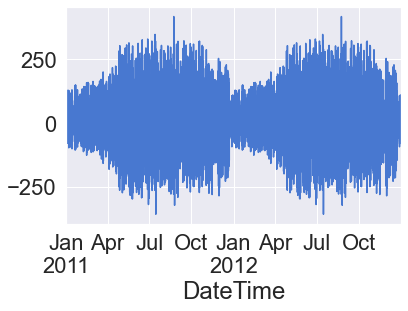

In [22]:
# result of duplication
data_fe["count_diff"].plot()

In [24]:
y_te.shift(2)

,count
DateTime,
2012-07-01 00:00:00,nan
2012-07-01 01:00:00,nan
2012-07-01 02:00:00,149.00
2012-07-01 03:00:00,93.00
2012-07-01 04:00:00,90.00
...,...
2012-12-31 19:00:00,164.00
2012-12-31 20:00:00,122.00
2012-12-31 21:00:00,119.00


In [25]:
# calculation of lag data from Y
x_te["count_lag1"] = y_te.shift(1).values
x_te["count_lag1"].fillna(method="bfill", inplace=True)
x_te["count_lag2"] = y_te.shift(2).values
x_te["count_lag2"].fillna(method="bfill", inplace=True)
x_te["count_lag2"]

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count_lag2, Length: 4416, dtype: float64

In [26]:
def feature_engineering_lag_modified(y, x, target):
    for col in target:
        x[col] = y.shift(1).values
        x[col].fillna(method="bfill", inplace=True)
        x[col] = y.shift(2).values
        x[col].fillna(method="bfill", inplace=True)
    return x

target = ["count_lag1", "count_lag2"]
x_te = feature_engineering_lag_modified(y_te, x_te, target)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:54:12   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             2.7535      0.952      2.893      0.004       0.888       4.619
holiday            0.6180      3.170      0.195      0.845      -5.595       6.831
workingday         2.1960      1.544      1.423      0.155      -0.830       5.222
weather           -5.8817      0.780     -7.544      0.000      -7.410      -4.353
temp               0.5622      0.490      1.146      0.252      -0.399       1.523
atemp              0.4042      0.427      0.946      0.344      -0.433       1.242
humidity          -0.0706      0.028     -2.501      0.012      -0.126      -0.015
windspeed         -0.1216      0.057     -2.117      0.034      -0.234      -0.009
count_trend        0.0718      0.024      3.007      0.003       0.025       0.119
count_seasonal     0.1948      0.006     34.600      0.000       0.184       0.206
count_Day          0.1011      0.024      4.190      0.000       0.054       0.148
count_Week        -0.0801      0.026     -3.078      0.002      -0.131      -0.029
count_diff         0.7146      0.007     97.737      0.000       0.700       0.729
Year               0.0004      0.002      0.188      0.851      -0.003       0.004
Quater_ver2        5.6849      0.284     19.988      0.000       5.127       6.242
Month              1.1013      0.566      1.945      0.052      -0.009       2.211
Day               -0.0335      0.049     -0.681      0.496      -0.130       0.063
Hour               0.1185      0.083      1.420      0.156      -0.045       0.282
DayofWeek          0.3611      0.354      1.021      0.307      -0.332       1.055
count_lag1         0.9285      0.006    149.851      0.000       0.916       0.941
count_lag2        -0.1938      0.006    -33.734      0.000      -0.205      -0.183
Quater_Dummy_2    -7.2671      2.213     -3.284      0.001     -11.605      -2.929
Quater_Dummy_3   -21.5188      3.728     -5.773      0.000     -28.825     -14.212
Quater_Dummy_4   -26.7509      5.511     -4.854      0.000     -37.554     -15.948
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.45,0.78,572.93,744.23,"2,927.28","7,390.92","46,108.47"
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"133,771.72",nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,two-sided


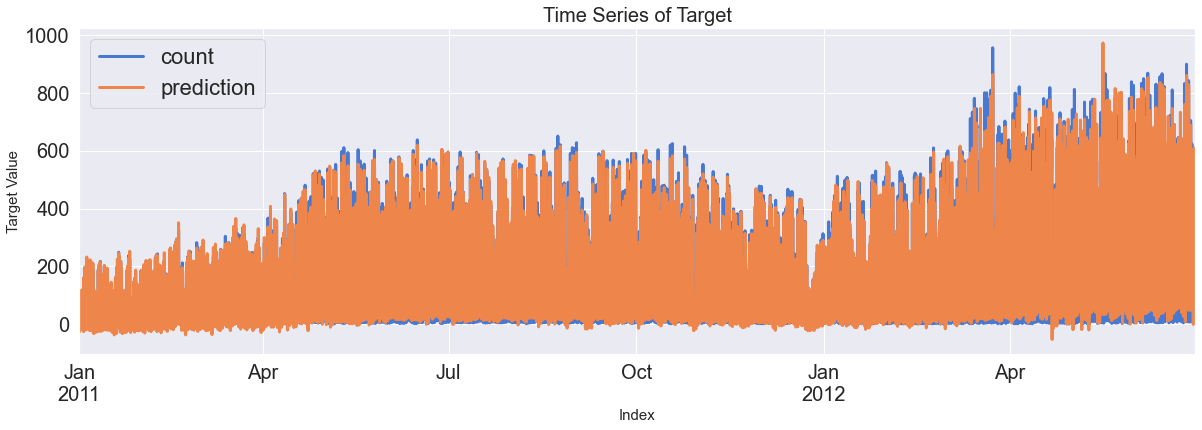

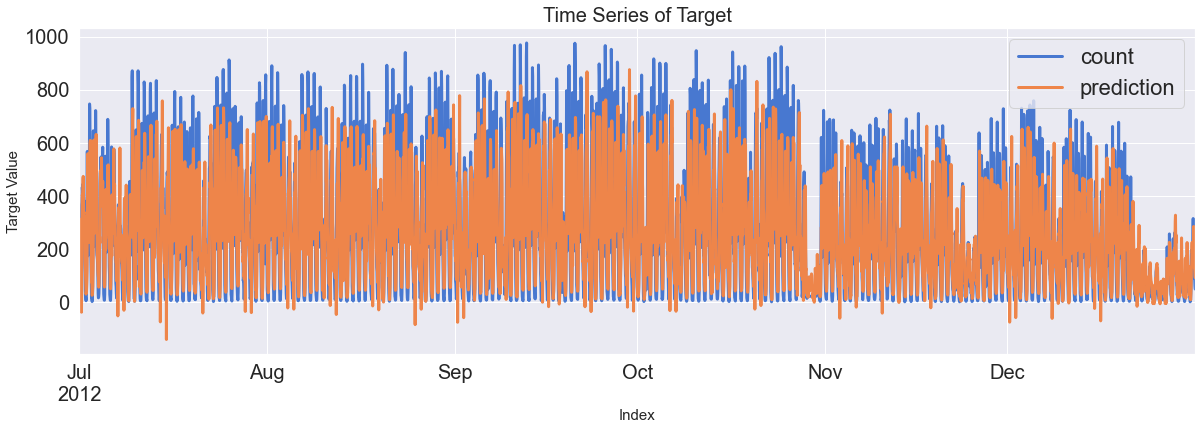

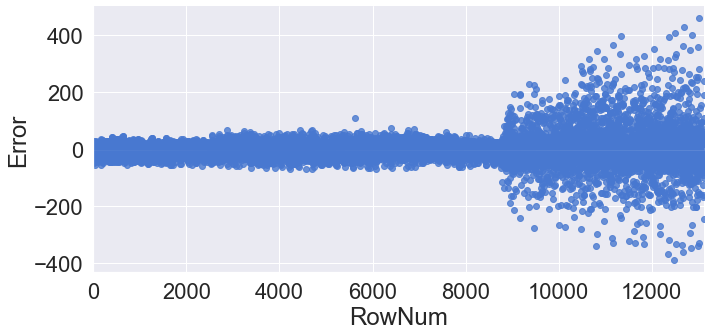

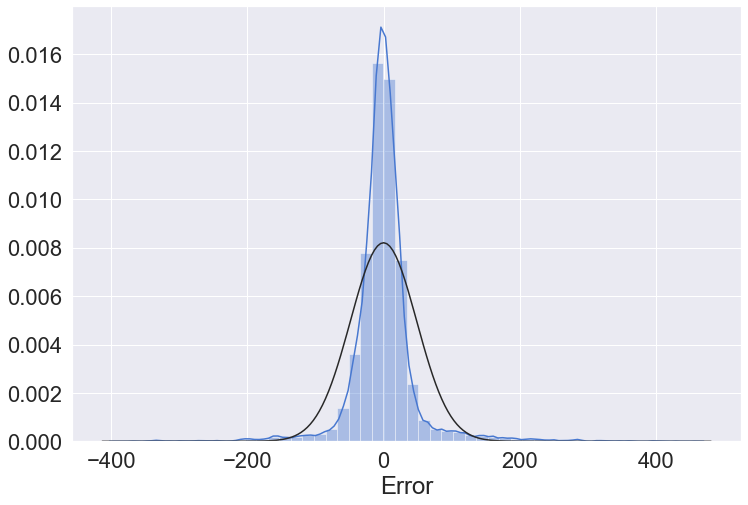

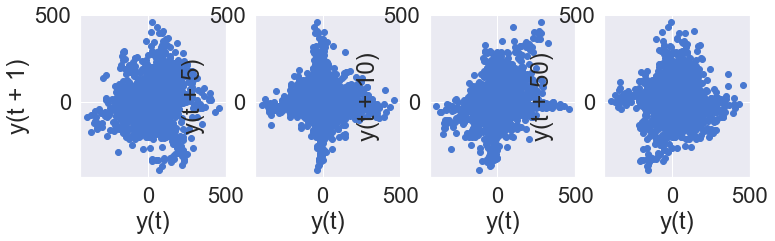

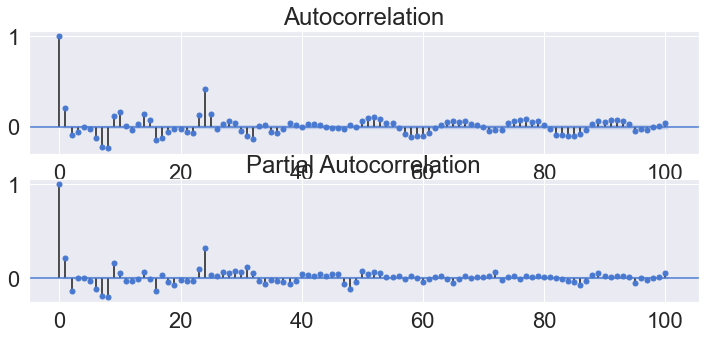

In [29]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_all = pd.read_csv(location)

# Feature Engineering
data_fe = feature_engineering(raw_all)
### Reality ###
target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_feR = duplicate_values(data_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
X_colname = [x for x in data_fe.columns if x not in Y_colname+X_remove]
x_tr_feR, x_teR, Y_train_feR, y_teR = datasplit_ts(data_feR, Y_colname, X_colname, "2012-07-01")
### Reality ###
target = ["count_lag1", "count_lag2"]
x_teR = feature_engineering_lag_modified(y_teR, x_teR, target)
###############

# Applying Base Model
fit = sm.OLS(Y_train_feR, x_tr_feR).fit()
display(fit.summary())
pred_tr_reg1_feR = fit.predict(x_tr_feR).values
pred_te_reg1_feR = fit.predict(x_teR).values

# Evaluation
Score_reg1_feR, Resid_tr_reg1_feR, Resid_te_reg1_feR = evaluation_trte(Y_train_feR, pred_tr_reg1_feR, y_teR, pred_te_reg1_feR, graph_on=True)
display(Score_reg1_feR)

# Error Analysis
error_analysis(Resid_tr_reg1_feR, ["Error"], x_tr_feR, graph_on=True)

In [30]:
display(Score_reg1_rd)
display(Score_reg1_fe)
display(Score_reg1_feR)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


## 변수간스케일조정

In [31]:
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(x_tr_feR)
x_tr_feRS = pd.DataFrame(scaler_fit.transform(x_tr_feR), 
                                       index=x_tr_feR.index, columns=x_tr_feR.columns)
x_teRS = pd.DataFrame(scaler_fit.transform(x_teR), 
                           index=x_teR.index, columns=x_teR.columns)
x_teRS.describe().T

,count,mean,std,min,25%,50%,75%,max
season,"4,416.00",0.79,0.26,0.00,0.67,0.67,1.00,1.00
holiday,"4,416.00",0.03,0.18,0.00,0.00,0.00,0.00,1.00
workingday,"4,416.00",0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"4,416.00",0.15,0.21,0.00,0.00,0.00,0.33,0.67
temp,"4,416.00",0.54,0.20,0.12,0.35,0.56,0.71,1.02
atemp,"4,416.00",0.51,0.17,0.15,0.36,0.53,0.65,0.91
humidity,"4,416.00",0.64,0.17,0.16,0.50,0.65,0.78,1.00
windspeed,"4,416.00",0.20,0.14,0.00,0.12,0.19,0.30,0.77
count_trend,"4,416.00",0.57,0.18,0.02,0.48,0.60,0.70,1.00
count_seasonal,"4,416.00",0.40,0.28,0.00,0.14,0.45,0.54,1.00


In [32]:
# calculation from scaling parameters and fitting to test set
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(x_tr_feR)
x_tr_feRS = pd.DataFrame(scaler_fit.transform(x_tr_feR), 
                           index=x_tr_feR.index, columns=x_tr_feR.columns)
x_teRS = pd.DataFrame(scaler_fit.transform(x_teR), 
                           index=x_teR.index, columns=x_teR.columns)

### Code Summary (Scaling)

In [33]:
### Functionalize
### scaling of x_tr and X_test by x_tr_scaler
def feature_engineering_scaling(scaler, x_tr, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(x_tr)
    x_tr_scaling = pd.DataFrame(scaler_fit.transform(x_tr), 
                               index=x_tr.index, columns=x_tr.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return x_tr_scaling, X_test_scaling
# x_tr_feRS, x_teRS = feature_engineering_scaling(preprocessing.Normalizer(), x_tr_feR, x_teR)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.201e+04
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:54:18   Log-Likelihood:                         -69508.
No. Observations:               13128   AIC:                                  1.391e+05
Df Residuals:                   13104   BIC:                                  1.392e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season          4315.6193   1933.052      2.233      0.026     526.557    8104.681
holiday         -409.2134   6443.851     -0.064      0.949    -1.3e+04    1.22e+04
workingday      2915.8573   3150.917      0.925      0.355   -3260.397    9092.112
weather        -1.105e+04   1587.055     -6.965      0.000   -1.42e+04   -7943.631
temp            1593.7972   1005.124      1.586      0.113    -376.391    3563.986
atemp            112.3002    874.853      0.128      0.898   -1602.538    1827.138
humidity        -112.4943     57.480     -1.957      0.050    -225.163       0.174
windspeed       -241.9981    117.465     -2.060      0.039    -472.246     -11.750
count_trend      119.3792     48.631      2.455      0.014      24.055     214.703
count_seasonal   356.4902     11.505     30.985      0.000     333.938     379.042
count_Day        203.8292     49.125      4.149      0.000     107.538     300.120
count_Week      -114.3462     53.135     -2.152      0.031    -218.499     -10.194
count_diff      1524.5914     15.184    100.410      0.000    1494.829    1554.354
Year              -2.3743      3.796     -0.626      0.532      -9.815       5.066
Quater_ver2     1.118e+04    578.212     19.343      0.000    1.01e+04    1.23e+04
Month           2308.4692   1155.318      1.998      0.046      43.878    4573.060
Day              -42.2992    100.152     -0.422      0.673    -238.611     154.013
Hour             -88.0027    169.788     -0.518      0.604    -420.811     244.806
DayofWeek        298.0309    722.036      0.413      0.680   -1117.264    1713.326
count_lag1      2036.3774     12.950    157.255      0.000    2010.994    2061.760
count_lag2      -384.2636     12.038    -31.921      0.000    -407.859    -360.668
Quater_Dummy_2 -1.317e+04   4509.968     -2.919      0.004    -2.2e+04   -4325.329
Quater_Dummy_3 -4.321e+04   7615.435     -5.674      0.000   -5.81e+04   -2.83e+04
Quater_Dummy_4 -5.415e+04   1.13e+04     -4.810      0.000   -7.62e+04   -3.21e+04
==============================================================================
Omnibus:                     3787.573   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           125389.728
Skew:                           0.737   Prob(JB):                         0.00
Kurtosis:                      18.069   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.69,0.78,585.36,715.46,"2,798.72","7,261.76",477.22
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,40.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"133,677.59",nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,two-sided


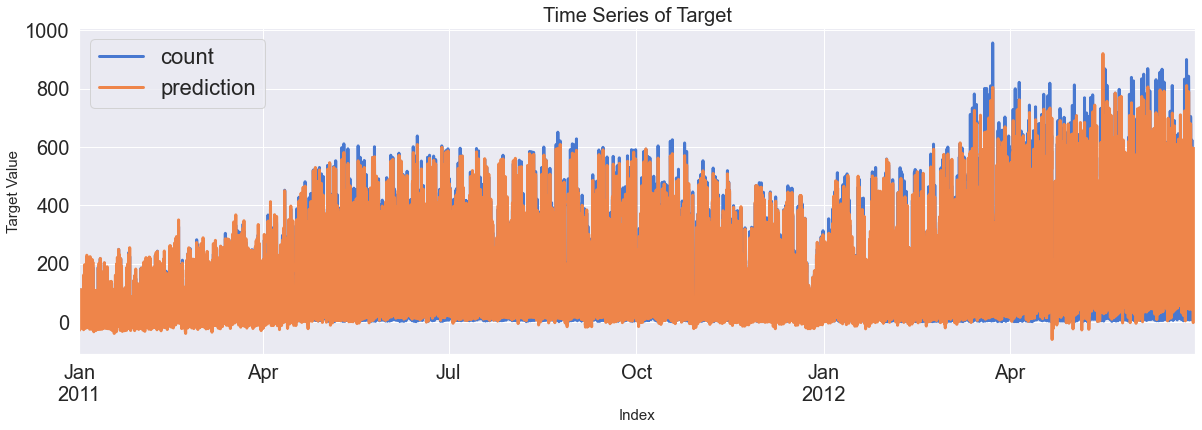

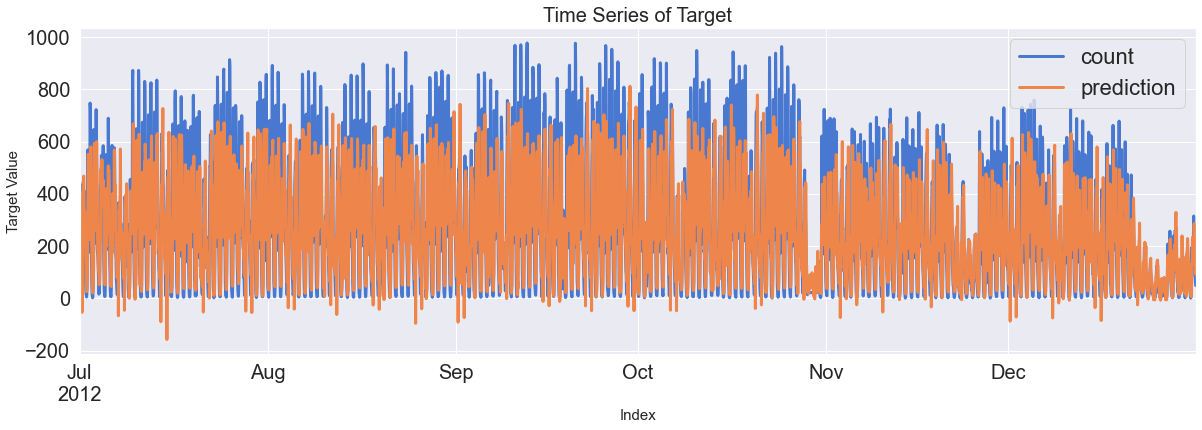

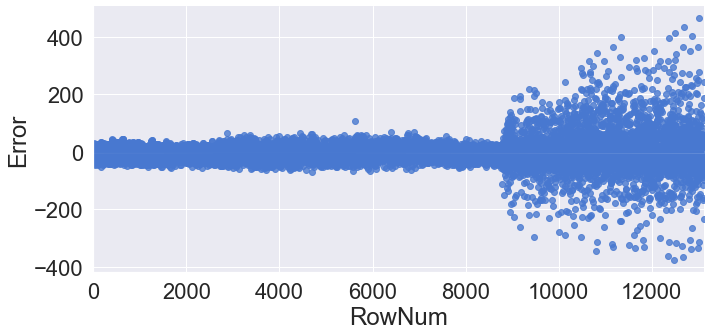

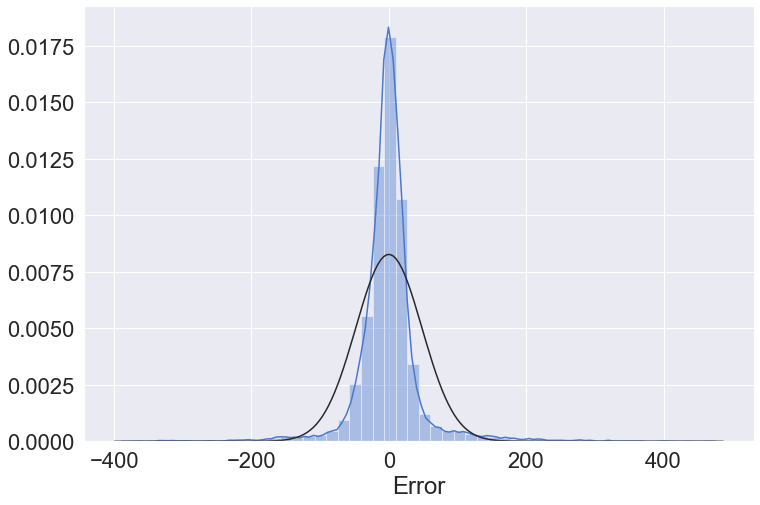

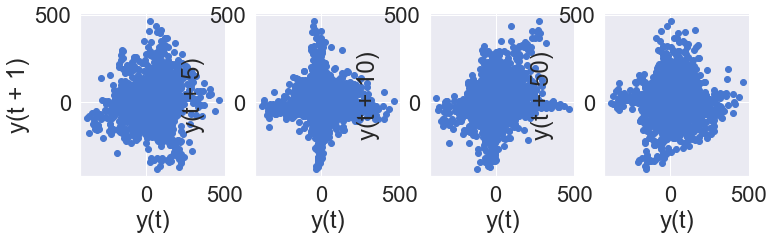

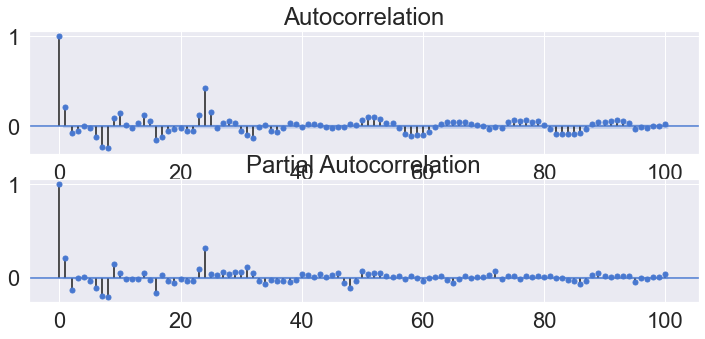

In [34]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_all = pd.read_csv(location)

# Feature Engineering
data_fe = feature_engineering(raw_all)
### Reality ###
target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_feR = duplicate_values(data_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
X_colname = [x for x in data_fe.columns if x not in Y_colname+X_remove]
x_tr_feR, x_teR, Y_train_feR, y_teR = datasplit_ts(data_feR, Y_colname, X_colname, "2012-07-01")
### Reality ###
target = ["count_lag1", "count_lag2"]
x_teR = feature_engineering_lag_modified(y_teR, x_teR, target)
###############
### Scaling ###
x_tr_feRS, x_teRS = feature_engineering_scaling(preprocessing.Normalizer(), x_tr_feR, x_teR)
###############

# Applying Base Model
fit_reg1_feRS = sm.OLS(Y_train_feR, x_tr_feRS).fit()
display(fit_reg1_feRS.summary())
pred_tr_reg1_feRS = fit_reg1_feRS.predict(x_tr_feRS).values
pred_te_reg1_feRS = fit_reg1_feRS.predict(x_teRS).values

# Evaluation
Score_reg1_feRS, Resid_tr_reg1_feRS, Resid_te_reg1_feRS = evaluation_trte(Y_train_feR, pred_tr_reg1_feRS,
                                                                   y_teR, pred_te_reg1_feRS, graph_on=True)
display(Score_reg1_feRS)

# Error Analysis
error_analysis(Resid_tr_reg1_feRS, ["Error"], x_tr_feRS, graph_on=True)

In [35]:
display(Score_reg1_rd)
display(Score_reg1_fe)
display(Score_reg1_feR)
display(Score_reg1_feRS)


,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


## 다중공선성제거

In [36]:
data_feR.corr().loc[:, ["casual", "registered", "count"]]

,casual,registered,count
season,0.12,0.18,0.18
holiday,0.03,-0.05,-0.04
workingday,-0.30,0.13,0.03
weather,-0.16,-0.13,-0.15
temp,0.46,0.34,0.41
atemp,0.46,0.34,0.41
humidity,-0.35,-0.28,-0.33
windspeed,0.08,0.07,0.08
casual,1.00,0.51,0.70
registered,0.51,1.00,0.97


In [37]:
# correlation from features
data_feR.corr().loc[:, ["casual", "registered", "count"]].style.background_gradient().set_precision(2).set_properties(**{"font-size": "11pt"})
# count_trend, count_seasonal, count_day, count_week, count_diff, Hour, count_lag1, count_lag2

,casual,registered,count
season,0.12,0.18,0.18
holiday,0.03,-0.05,-0.04
workingday,-0.30,0.13,0.03
weather,-0.16,-0.13,-0.15
temp,0.46,0.34,0.41
atemp,0.46,0.34,0.41
humidity,-0.35,-0.28,-0.33
windspeed,0.08,0.07,0.08
casual,1.00,0.51,0.70
registered,0.51,1.00,0.97


In [38]:
data_feR.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
count,"17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00"
mean,2.50,0.03,0.68,1.43,20.30,23.71,62.87,12.81,35.35,152.44,187.80,141.91,-0.16,141.82,141.60,-0.04,"2,011.50",4.51,6.52,15.74,11.51,3.00,187.79,187.79,0.25,0.25,0.25
std,1.11,0.17,0.47,0.65,7.92,8.62,19.34,8.29,49.19,151.28,181.35,56.89,128.49,57.02,51.15,75.16,0.50,2.29,3.45,8.80,6.94,2.01,181.35,181.35,0.43,0.43,0.43
min,1.00,0.00,0.00,1.00,0.82,0.00,0.00,0.00,0.00,0.00,1.00,20.00,-181.67,19.96,45.95,-357.00,"2,011.00",1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,48.00,7.00,4.00,32.00,38.00,88.45,-125.09,88.33,94.80,-32.00,"2,011.00",3.00,4.00,8.00,5.00,1.00,38.00,38.00,0.00,0.00,0.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,63.00,13.00,16.00,114.00,140.00,155.10,19.32,155.19,159.72,-3.00,"2,012.00",5.00,7.00,16.00,12.00,3.00,140.00,140.00,0.00,0.00,0.00
75%,3.00,0.00,1.00,2.00,27.06,31.06,79.00,17.00,48.00,219.00,279.00,190.04,64.52,190.12,185.03,23.00,"2,012.00",7.00,10.00,23.00,17.25,5.00,279.00,279.00,0.00,1.00,1.00
max,4.00,1.00,1.00,4.00,41.00,50.00,100.00,57.00,367.00,886.00,977.00,269.65,273.37,269.88,217.98,417.00,"2,012.00",8.00,12.00,31.00,23.00,6.00,977.00,977.00,1.00,1.00,1.00


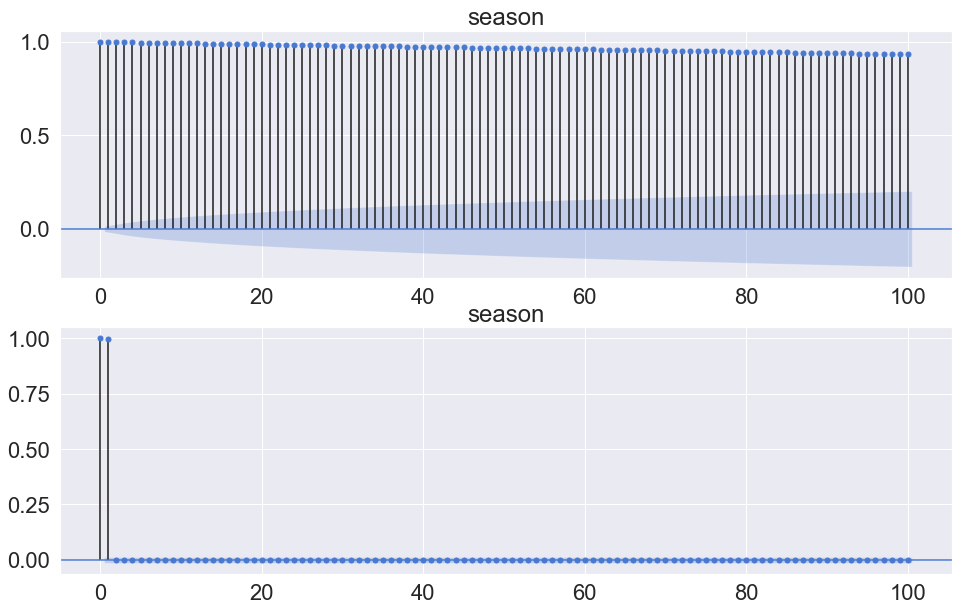

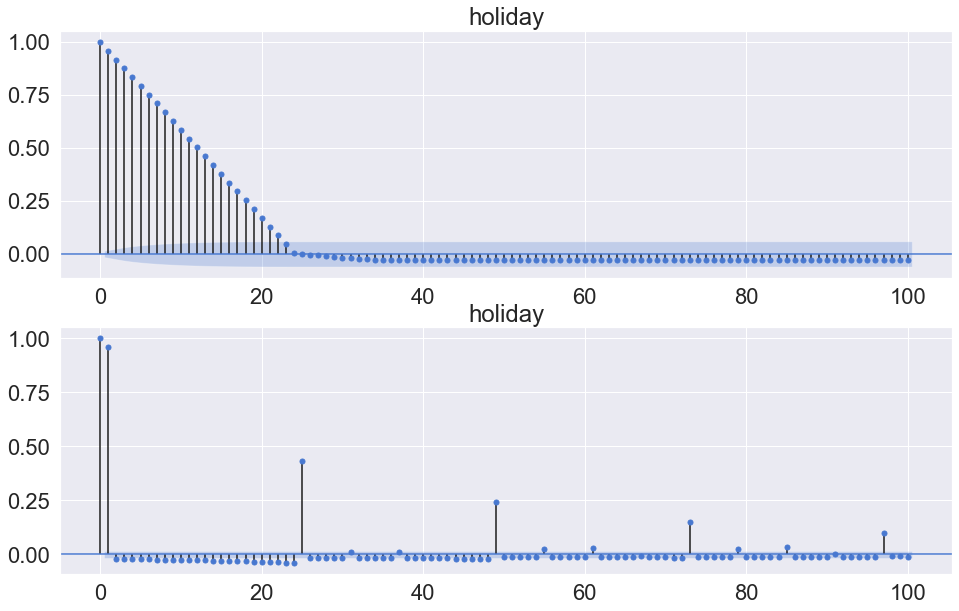

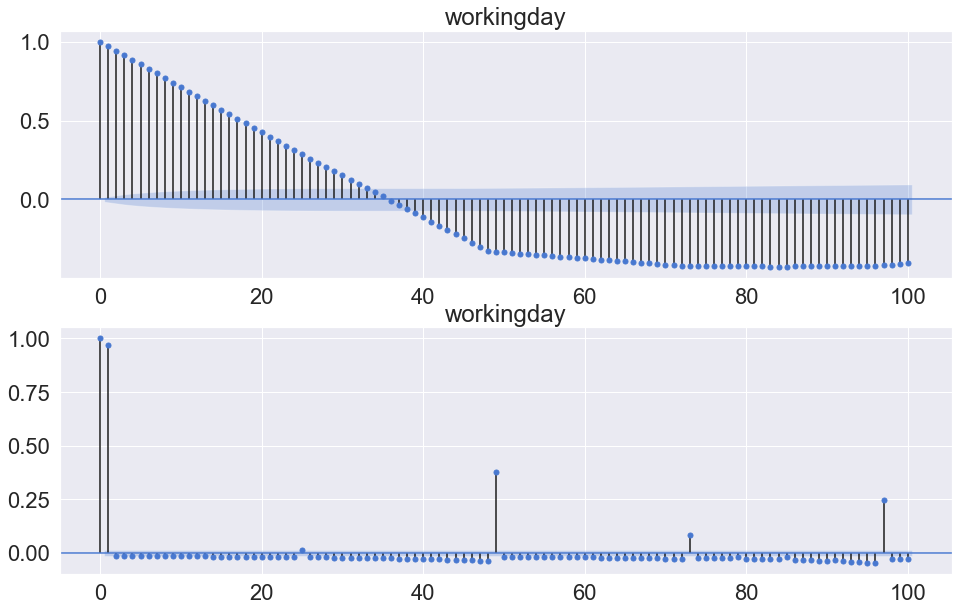

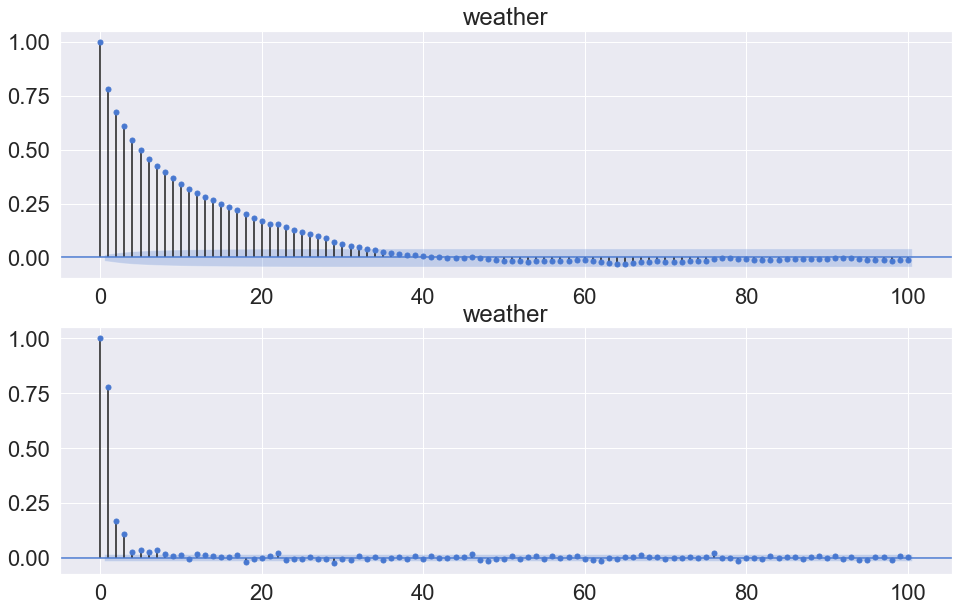

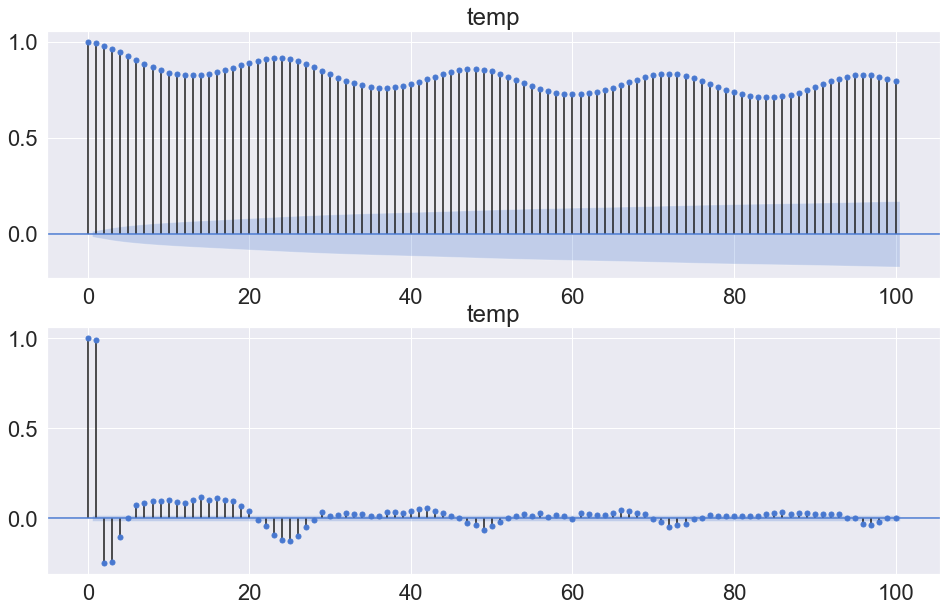

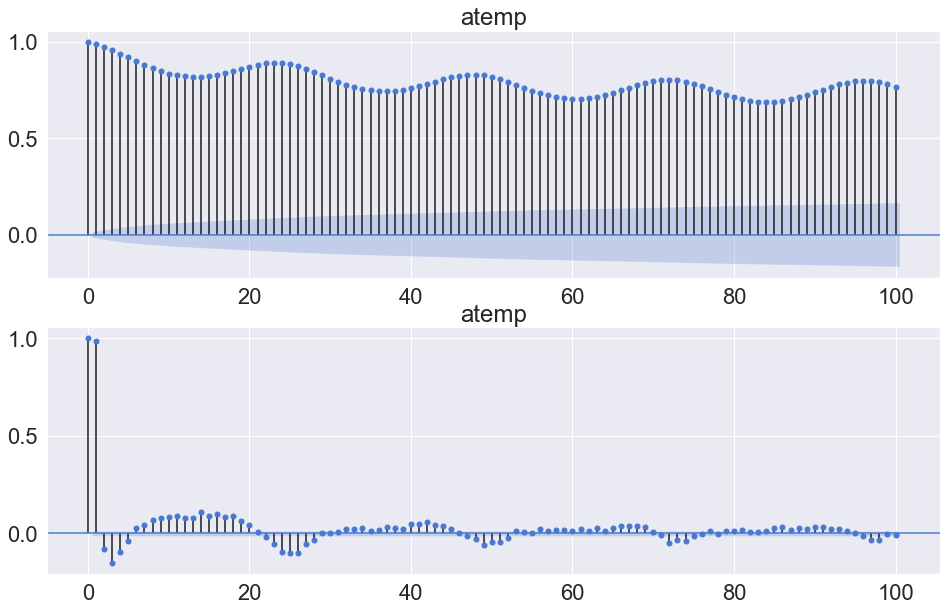

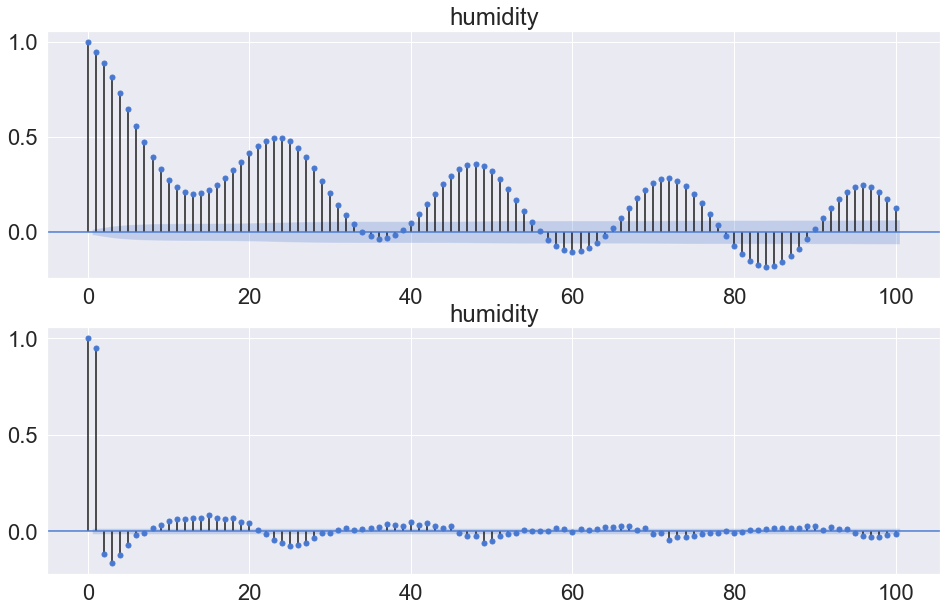

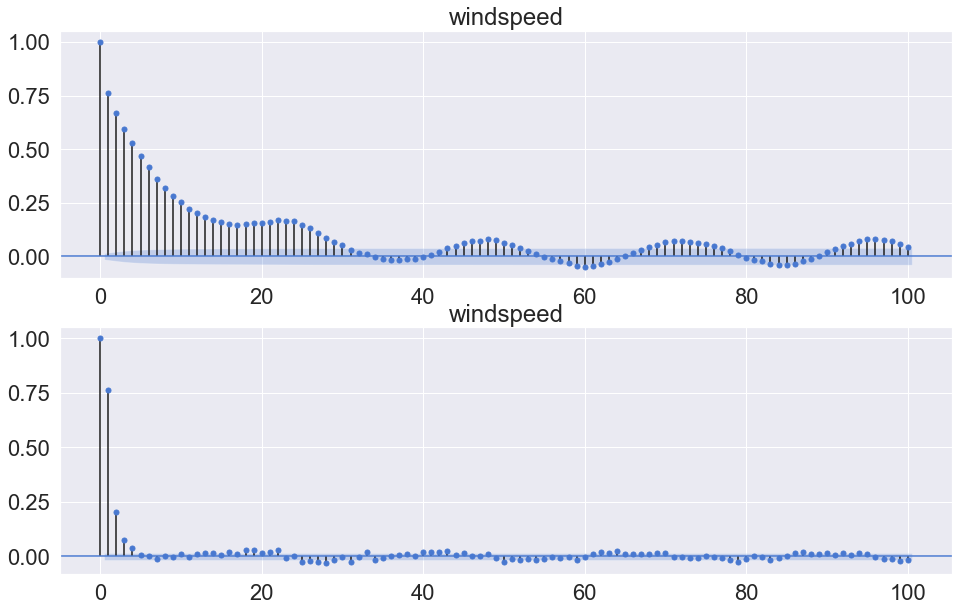

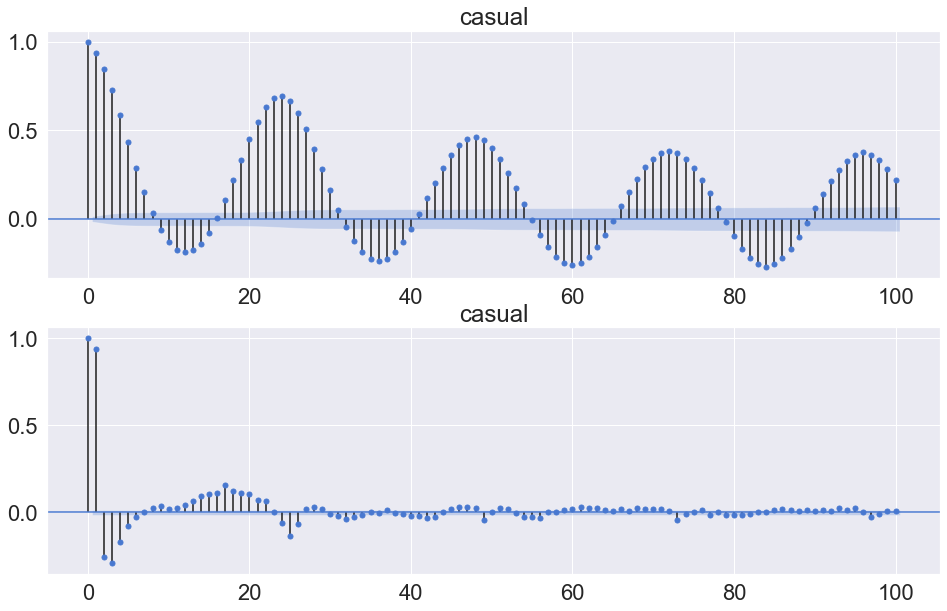

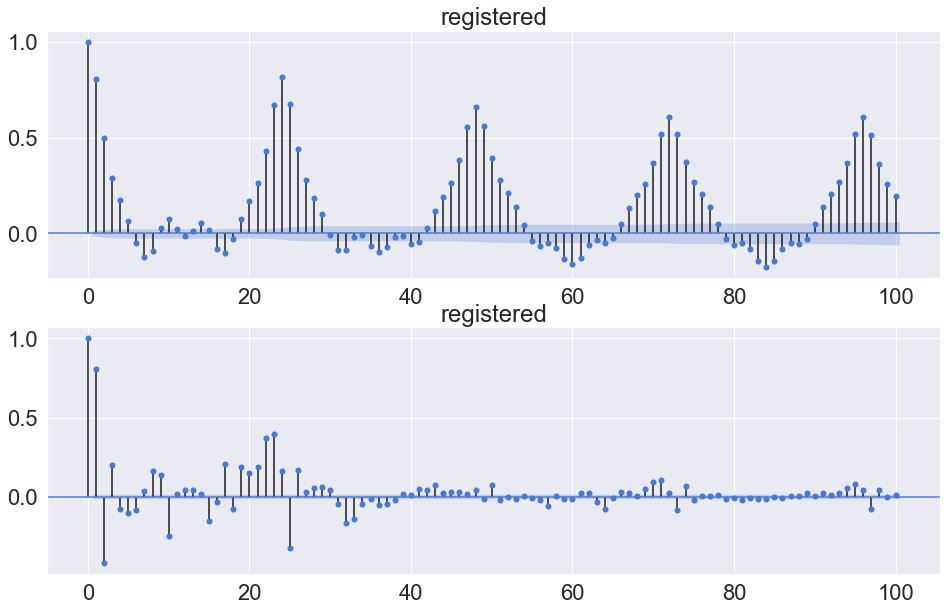

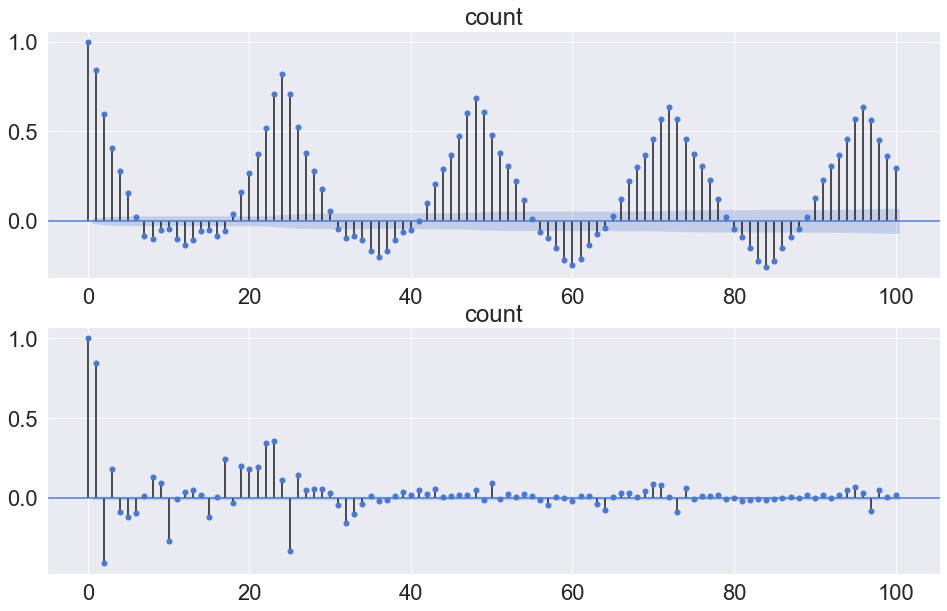

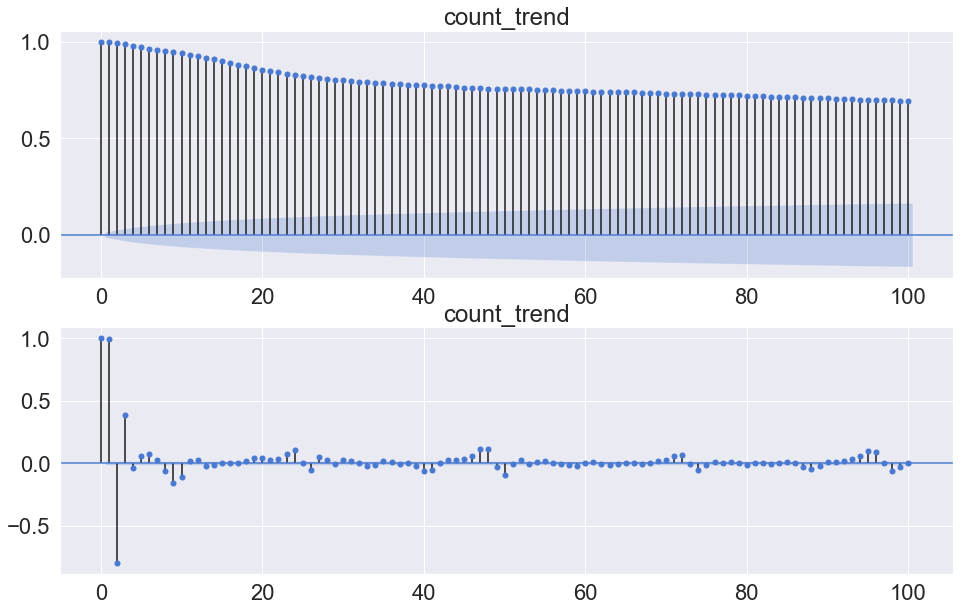

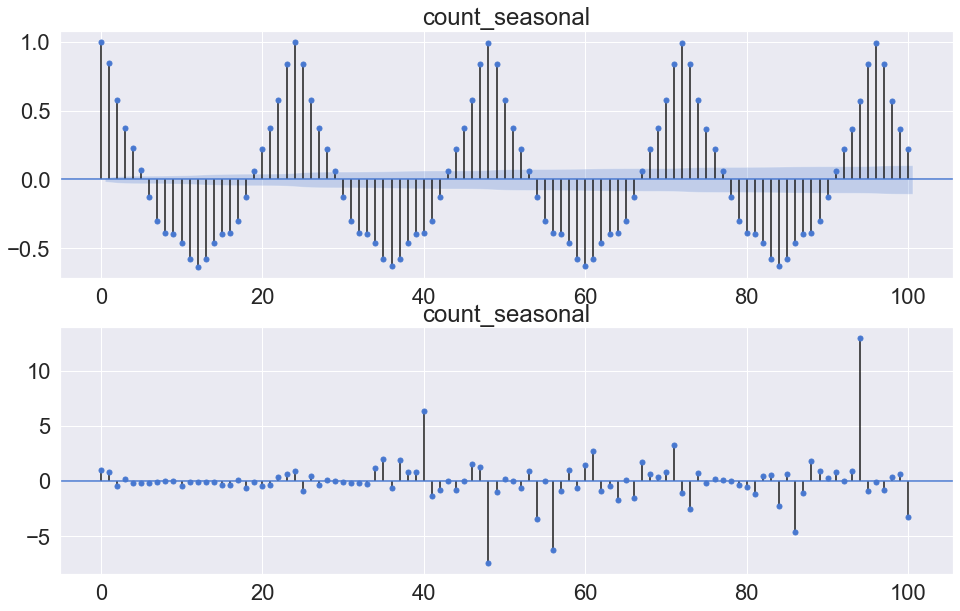

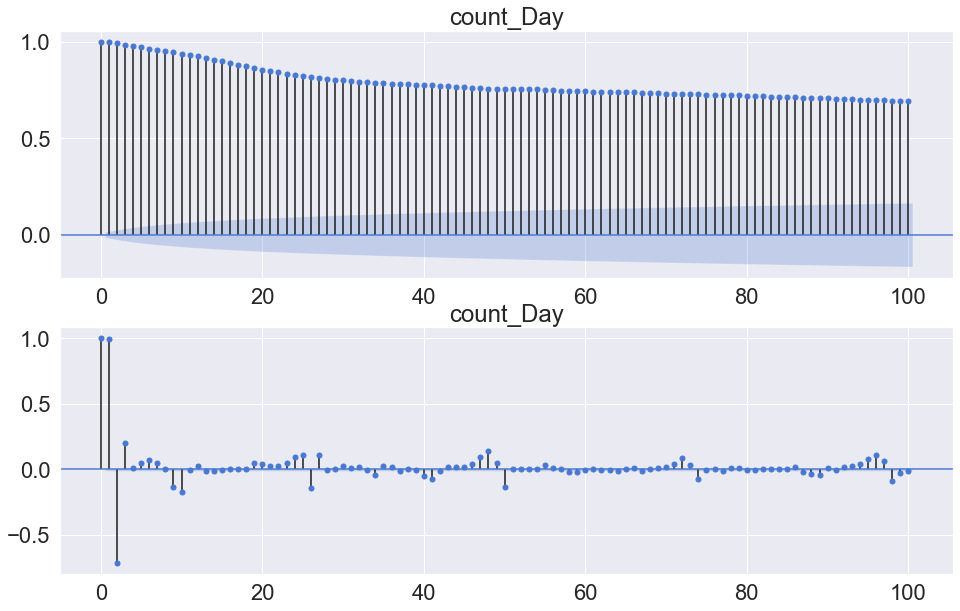

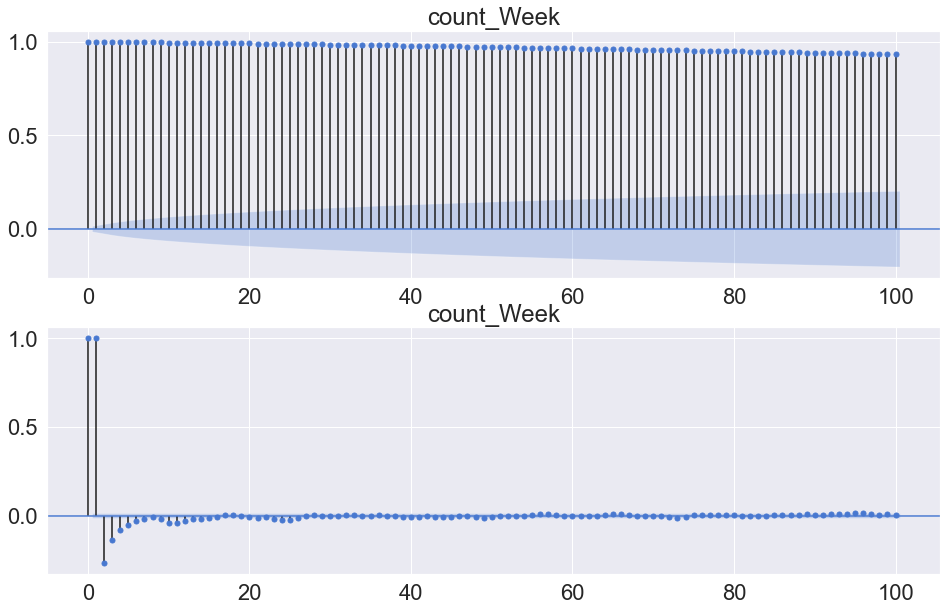

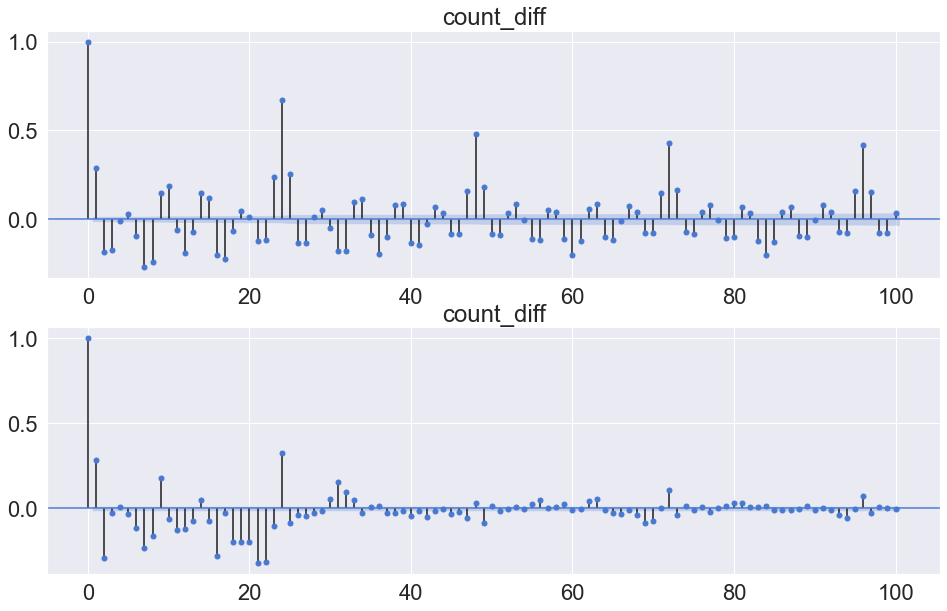

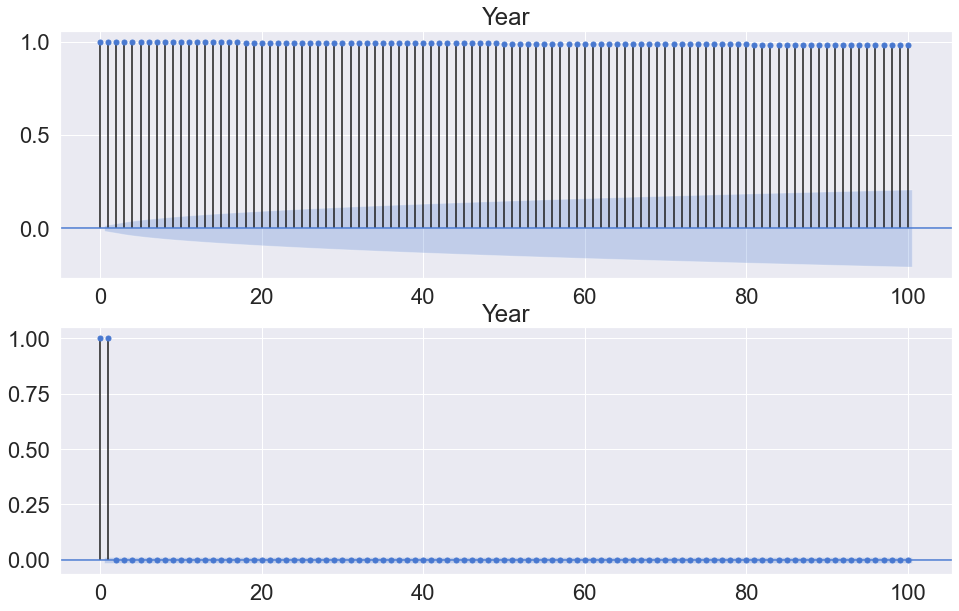

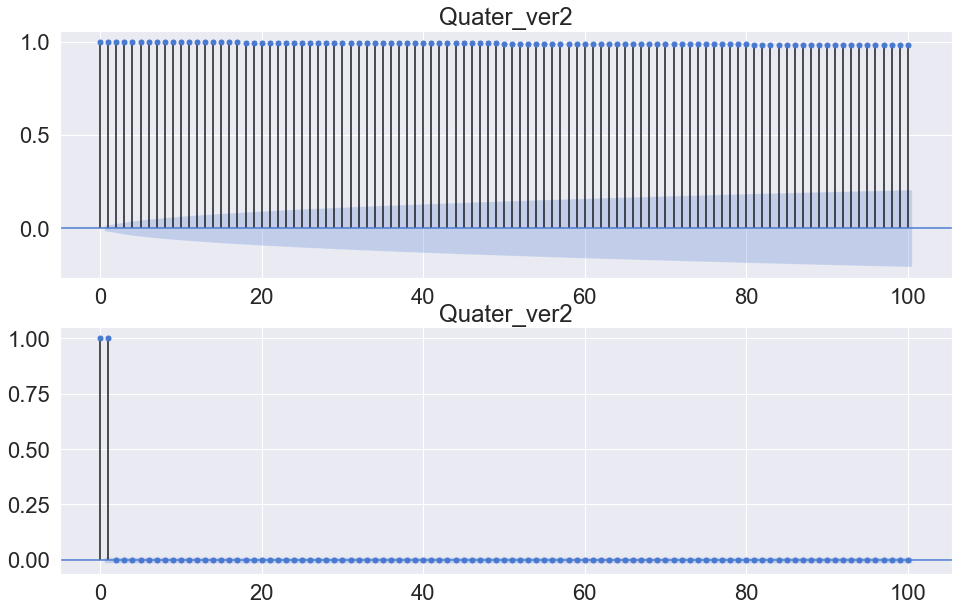

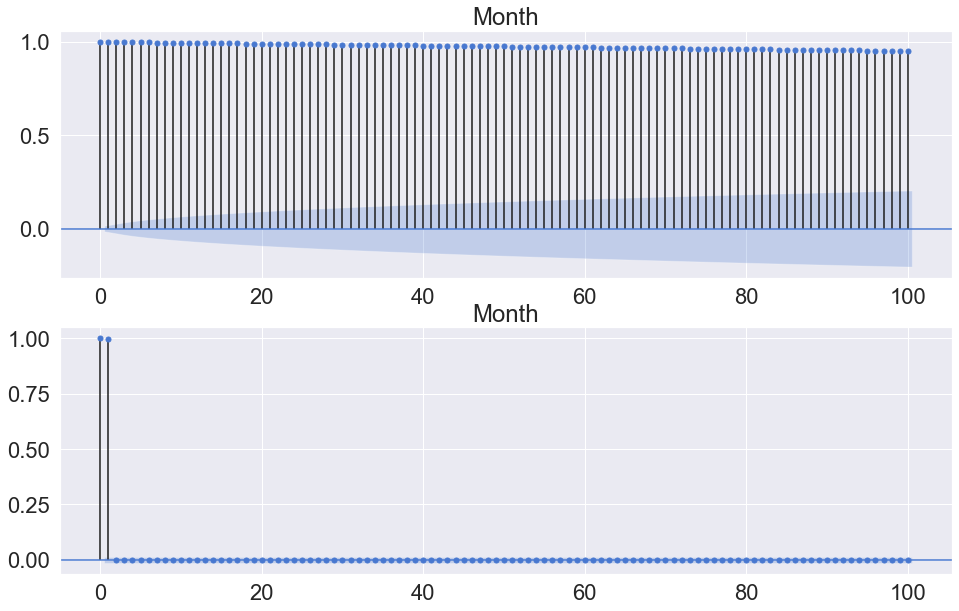

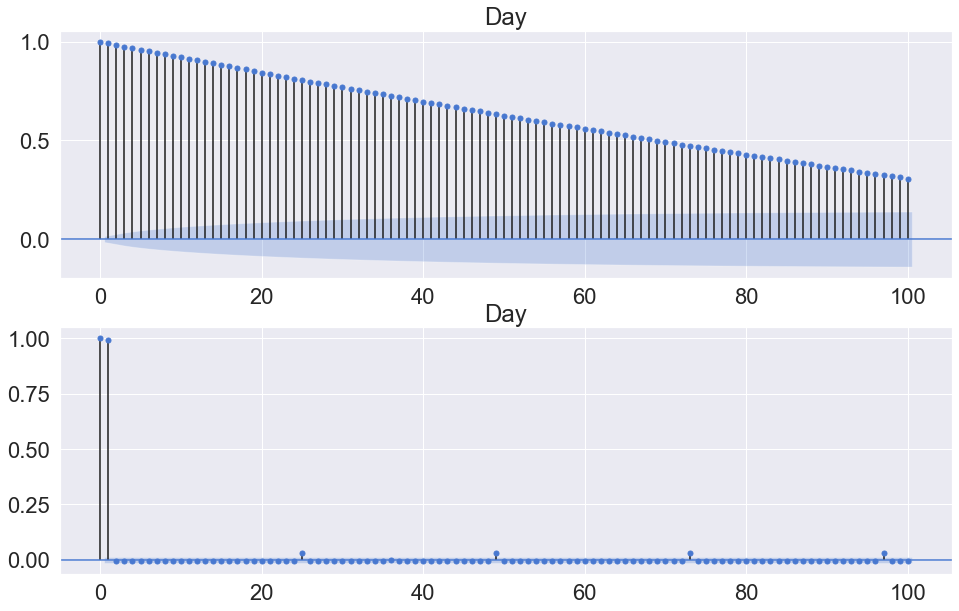

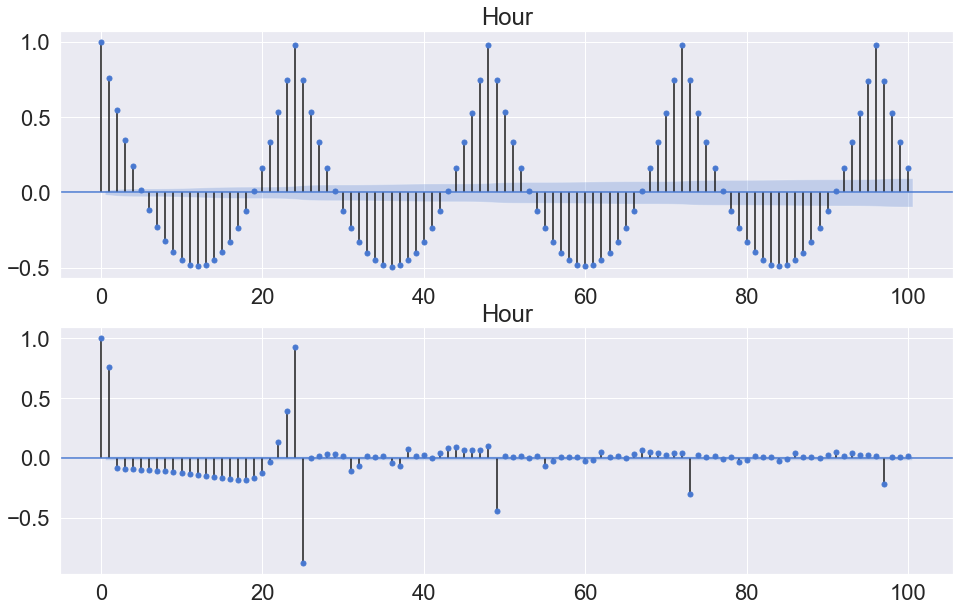

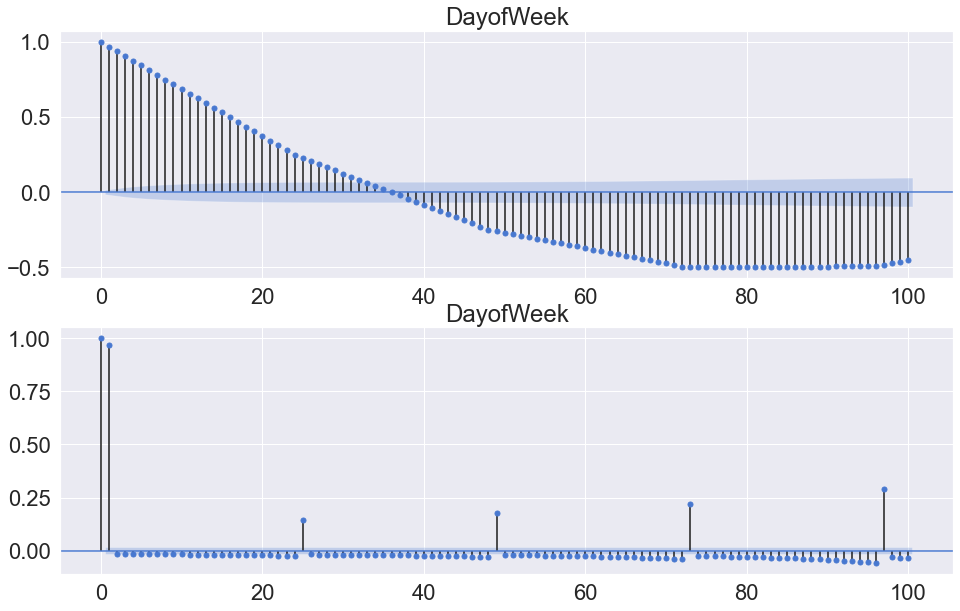

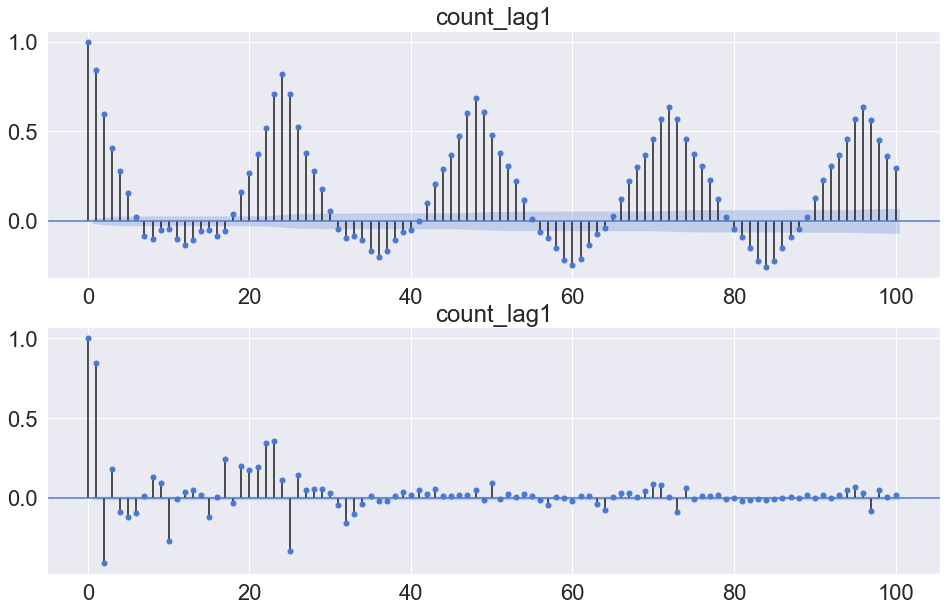

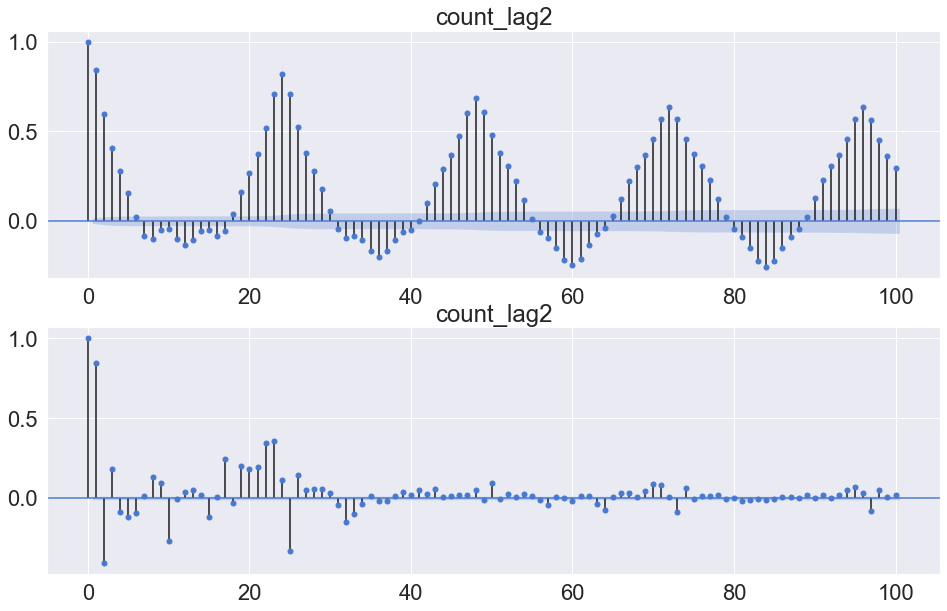

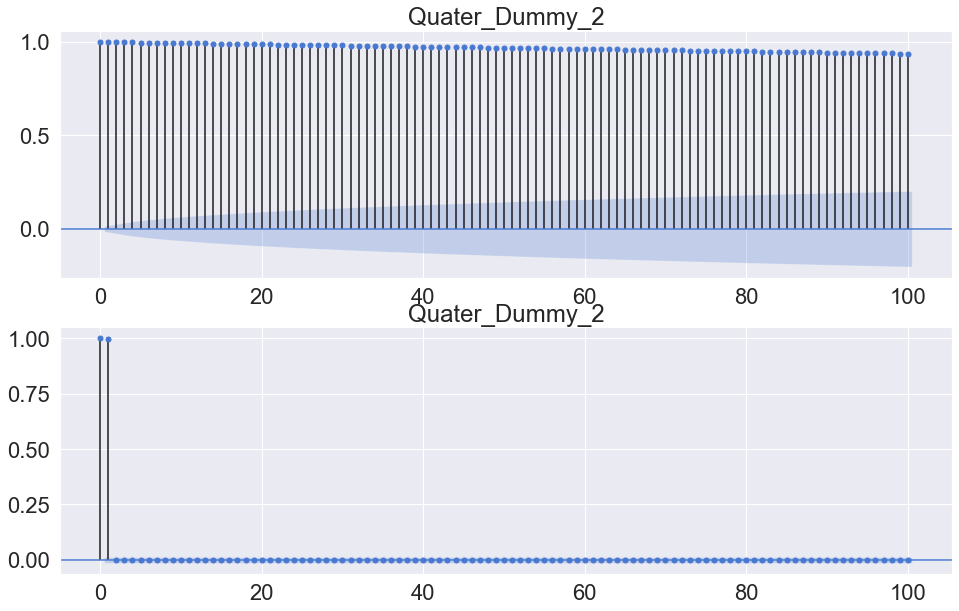

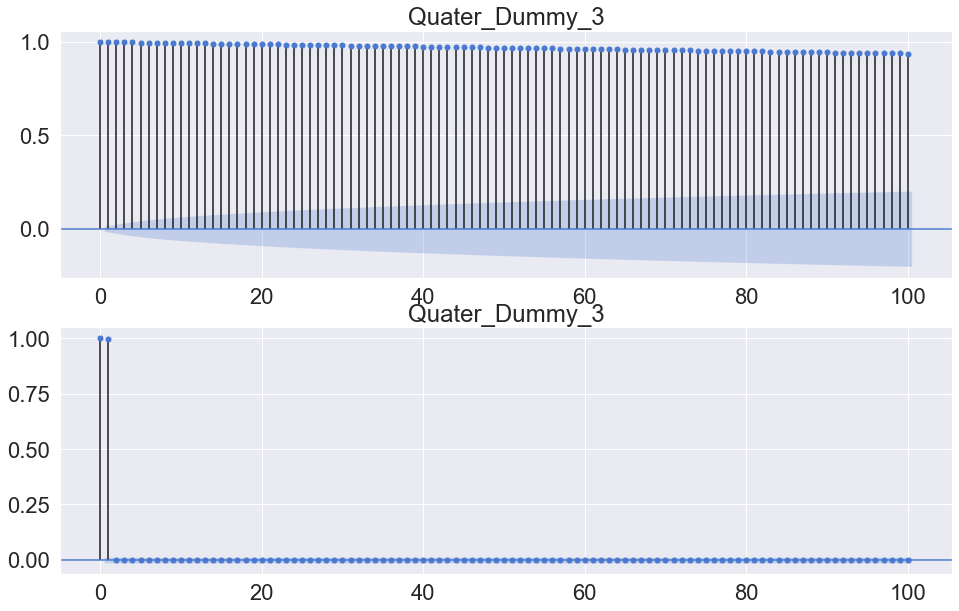

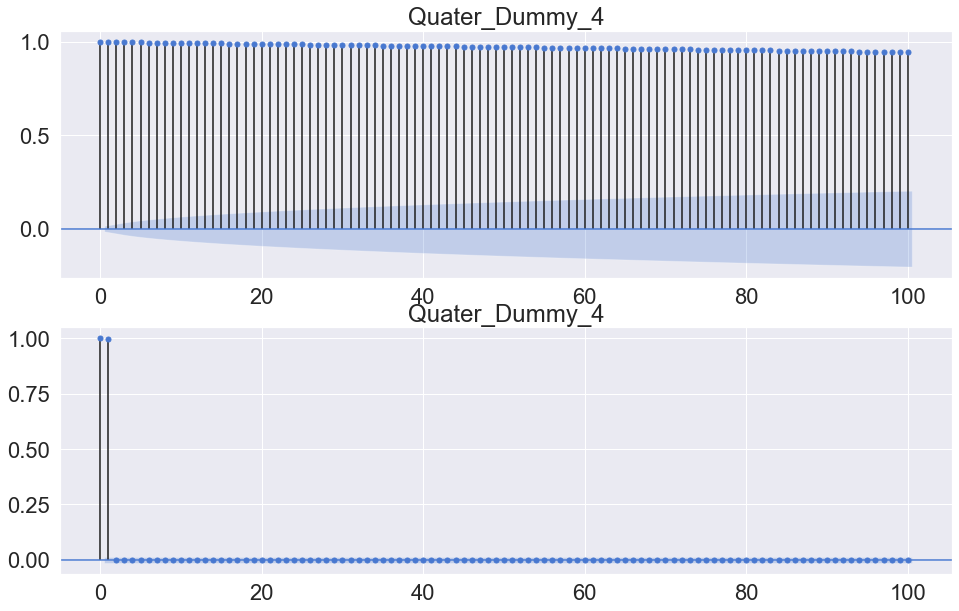

In [39]:
for col in data_feR.describe().columns:
    target = data_feR[col]
    figure, axes = plt.subplots(2,1,figsize=(16,10))
    sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes[0], title=col)
    sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes[1], title=col)  
#     figure, axes = plt.subplots(1,1,figsize=(16,5))
# #     sm.graphics.tsa.plot_acf(target, lags=100, use_vlines=True, ax=axes, title=col)
#     sm.graphics.tsa.plot_pacf(target, lags=100, use_vlines=True, ax=axes, title=col)
# count_trend, count_seasonal, count_day, count_week, count_diff, Hour, DayofWeek, count_lag1, count_lag2

In [40]:
data_feR.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{"font-size": "11pt"})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
season,1.00,-0.02,0.02,-0.02,0.32,0.33,0.15,-0.14,0.55,0.00,0.55,0.63,0.00,-0.00,0.42,0.83,-0.00,-0.01,-0.01,0.18,0.18,-0.20,0.31,0.60
holiday,-0.02,1.00,-0.26,-0.00,-0.04,-0.04,-0.01,0.01,-0.07,-0.00,-0.06,-0.02,-0.00,0.00,0.01,0.01,-0.01,0.01,-0.19,-0.04,-0.04,-0.03,-0.03,0.05
workingday,0.02,-0.26,1.00,0.04,0.05,0.05,0.02,-0.02,0.02,0.00,0.03,0.01,0.00,0.00,-0.00,-0.00,0.01,-0.00,-0.70,0.03,0.02,0.01,0.01,-0.02
weather,-0.02,-0.00,0.04,1.00,-0.11,-0.11,0.43,0.05,-0.18,-0.00,-0.12,-0.06,-0.01,-0.02,-0.02,0.00,0.01,-0.02,-0.06,-0.14,-0.14,-0.03,-0.07,0.05
temp,0.32,-0.04,0.05,-0.11,1.00,0.99,-0.07,-0.02,0.70,0.17,0.71,0.77,0.00,0.05,0.14,0.21,0.02,0.14,-0.03,0.41,0.40,0.26,0.60,-0.31
atemp,0.33,-0.04,0.05,-0.11,0.99,1.00,-0.06,-0.06,0.70,0.16,0.71,0.76,-0.00,0.05,0.15,0.22,0.02,0.13,-0.03,0.41,0.40,0.27,0.58,-0.29
humidity,0.15,-0.01,0.02,0.43,-0.07,-0.06,1.00,-0.27,0.01,-0.34,0.04,0.13,-0.01,-0.08,0.00,0.16,0.03,-0.27,-0.04,-0.33,-0.31,-0.03,0.06,0.10
windspeed,-0.14,0.01,-0.02,0.05,-0.02,-0.06,-0.27,1.00,-0.16,0.19,-0.16,-0.13,0.02,-0.01,-0.07,-0.13,0.02,0.14,-0.00,0.08,0.06,0.04,-0.10,-0.06
count_trend,0.55,-0.07,0.02,-0.18,0.70,0.70,0.01,-0.16,1.00,0.00,0.93,0.86,0.00,-0.00,0.22,0.45,-0.01,-0.00,-0.00,0.30,0.30,0.30,0.43,0.00
count_seasonal,0.00,-0.00,0.00,-0.00,0.17,0.16,-0.34,0.19,0.00,1.00,0.00,0.00,0.20,-0.00,-0.00,0.00,-0.00,0.55,0.00,0.60,0.41,0.00,0.00,0.00


In [41]:
# correlation from features
data_feR.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{"font-size": "11pt"})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
season,1.00,-0.02,0.02,-0.02,0.32,0.33,0.15,-0.14,0.55,0.00,0.55,0.63,0.00,-0.00,0.42,0.83,-0.00,-0.01,-0.01,0.18,0.18,-0.20,0.31,0.60
holiday,-0.02,1.00,-0.26,-0.00,-0.04,-0.04,-0.01,0.01,-0.07,-0.00,-0.06,-0.02,-0.00,0.00,0.01,0.01,-0.01,0.01,-0.19,-0.04,-0.04,-0.03,-0.03,0.05
workingday,0.02,-0.26,1.00,0.04,0.05,0.05,0.02,-0.02,0.02,0.00,0.03,0.01,0.00,0.00,-0.00,-0.00,0.01,-0.00,-0.70,0.03,0.02,0.01,0.01,-0.02
weather,-0.02,-0.00,0.04,1.00,-0.11,-0.11,0.43,0.05,-0.18,-0.00,-0.12,-0.06,-0.01,-0.02,-0.02,0.00,0.01,-0.02,-0.06,-0.14,-0.14,-0.03,-0.07,0.05
temp,0.32,-0.04,0.05,-0.11,1.00,0.99,-0.07,-0.02,0.70,0.17,0.71,0.77,0.00,0.05,0.14,0.21,0.02,0.14,-0.03,0.41,0.40,0.26,0.60,-0.31
atemp,0.33,-0.04,0.05,-0.11,0.99,1.00,-0.06,-0.06,0.70,0.16,0.71,0.76,-0.00,0.05,0.15,0.22,0.02,0.13,-0.03,0.41,0.40,0.27,0.58,-0.29
humidity,0.15,-0.01,0.02,0.43,-0.07,-0.06,1.00,-0.27,0.01,-0.34,0.04,0.13,-0.01,-0.08,0.00,0.16,0.03,-0.27,-0.04,-0.33,-0.31,-0.03,0.06,0.10
windspeed,-0.14,0.01,-0.02,0.05,-0.02,-0.06,-0.27,1.00,-0.16,0.19,-0.16,-0.13,0.02,-0.01,-0.07,-0.13,0.02,0.14,-0.00,0.08,0.06,0.04,-0.10,-0.06
count_trend,0.55,-0.07,0.02,-0.18,0.70,0.70,0.01,-0.16,1.00,0.00,0.93,0.86,0.00,-0.00,0.22,0.45,-0.01,-0.00,-0.00,0.30,0.30,0.30,0.43,0.00
count_seasonal,0.00,-0.00,0.00,-0.00,0.17,0.16,-0.34,0.19,0.00,1.00,0.00,0.00,0.20,-0.00,-0.00,0.00,-0.00,0.55,0.00,0.60,0.41,0.00,0.00,0.00


In [42]:
# extract effective features using variance inflation factor
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(x_tr_feRS.values, i) 
                     for i in range(x_tr_feRS.shape[1])]
vif["Feature"] = x_tr_feRS.columns
vif.sort_values(by="VIF_Factor", ascending=True)

,VIF_Factor,Feature
12,1.56,count_diff
1,1.61,holiday
9,2.89,count_seasonal
16,4.32,Day
7,4.51,windspeed
14,6.69,Quater_ver2
17,6.87,Hour
3,8.38,weather
21,8.83,Quater_Dummy_2
18,9.03,DayofWeek


In [43]:
# extract effective features using variance inflation factor
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(x_tr_feRS.values, i) 
                     for i in range(x_tr_feRS.shape[1])]
vif["Feature"] = x_tr_feRS.columns
vif.sort_values(by="VIF_Factor", ascending=True)["Feature"][:10].values

array(['count_diff', 'holiday', 'count_seasonal', 'Day', 'windspeed',
       'Quater_ver2', 'Hour', 'weather', 'Quater_Dummy_2', 'DayofWeek'],
      dtype=object)

### Code Summary (Multicollinearity)

In [44]:
### Functionalize
### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(x_tr, num_variables):
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(x_tr.values, i) 
                         for i in range(x_tr.shape[1])]
    vif["Feature"] = x_tr.columns
    X_colname_vif = vif.sort_values(by="VIF_Factor", ascending=True)["Feature"][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(x_tr_femm, 10)
# X_colname_vif

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.89it/s]


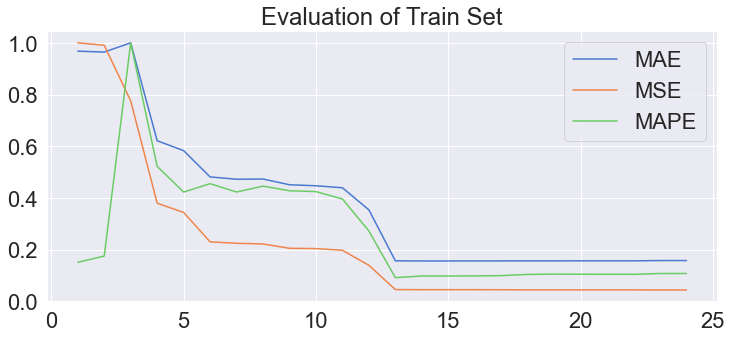

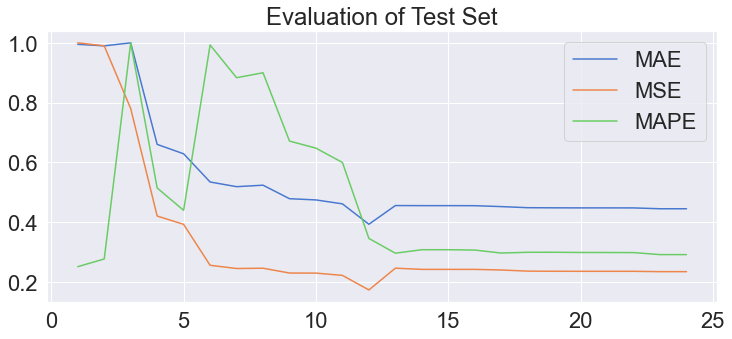

In [45]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_all = pd.read_csv(location)

# Feature Engineering
data_fe = feature_engineering(raw_all)
### Reality ###
target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_feR = duplicate_values(data_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
X_colname = [x for x in data_fe.columns if x not in Y_colname+X_remove]
x_tr_feR, x_teR, Y_train_feR, y_teR = datasplit_ts(data_feR, Y_colname, X_colname, "2012-07-01")
### Reality ###
target = ["count_lag1", "count_lag2"]
x_teR = feature_engineering_lag_modified(y_teR, x_teR, target)
###############
### Scaling ###
x_tr_feRS, x_teRS = feature_engineering_scaling(preprocessing.Normalizer(), x_tr_feR, x_teR)
###############

eval_tr = pd.DataFrame()
eval_te = pd.DataFrame()
for i in tqdm(range(1,len(x_tr_feRS.columns)+1)):
    X_colname_vif = feature_engineering_XbyVIF(x_tr_feRS, i)
#     print("Number_of_Selected_X: ", len(X_colname_vif))
    x_tr_feRSM, x_teRSM = x_tr_feRS[X_colname_vif].copy(), x_teRS[X_colname_vif].copy()
    
    # Applying Base Model
    fit_reg1_feRSM = sm.OLS(Y_train_feR, x_tr_feRSM).fit()
    pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(x_tr_feRSM).values
    pred_te_reg1_feRSM = fit_reg1_feRSM.predict(x_teRSM).values

    # Evaluation
    Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                       y_teR, pred_te_reg1_feRSM, graph_on=False)
    eval_tr = pd.concat([eval_tr, Score_reg1_feRSM.loc[["Train"]]], axis=0)
    eval_te = pd.concat([eval_te, Score_reg1_feRSM.loc[["Test"]]], axis=0)
eval_tr.index = range(1,len(x_tr_feRS.columns)+1)
eval_te.index = range(1,len(x_tr_feRS.columns)+1)

plt.figure(figsize=(12,5))
plt.plot(eval_tr.index, eval_tr/eval_tr.max())
plt.legend(eval_tr.columns)
plt.title("Evaluation of Train Set")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(eval_te.index, eval_te/eval_te.max())
plt.legend(eval_te.columns)
plt.title("Evaluation of Test Set")
plt.show()

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              6925.
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:54:49   Log-Likelihood:                         -77008.
No. Observations:               13128   AIC:                                  1.540e+05
Df Residuals:                   13116   BIC:                                  1.541e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
count_diff      1289.2806     25.881     49.816      0.000    1238.550    1340.011
holiday         7.141e+04   1.01e+04      7.044      0.000    5.15e+04    9.13e+04
count_seasonal  1270.9307     16.107     78.906      0.000    1239.359    1302.503
Day             1151.2606    168.230      6.843      0.000     821.505    1481.017
windspeed       -234.1084    180.733     -1.295      0.195    -588.370     120.154
Quater_ver2     2.865e+04    930.475     30.787      0.000    2.68e+04    3.05e+04
Hour           -3514.0425    282.316    -12.447      0.000   -4067.422   -2960.663
weather        -2.423e+04   2238.550    -10.825      0.000   -2.86e+04   -1.98e+04
Quater_Dummy_2  6.725e+04   3436.993     19.566      0.000    6.05e+04     7.4e+04
DayofWeek       1.621e+04    912.387     17.768      0.000    1.44e+04     1.8e+04
workingday      7.695e+04   4056.717     18.970      0.000     6.9e+04    8.49e+04
count_lag2      1061.0008     14.379     73.788      0.000    1032.816    1089.186
==============================================================================
Omnibus:                     1665.324   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5853.426
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                     1.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-10.30,0.95,"4,492.76","4,708.56","7,076.59","16,328.78",2.71
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"140,733.05",nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,two-sided


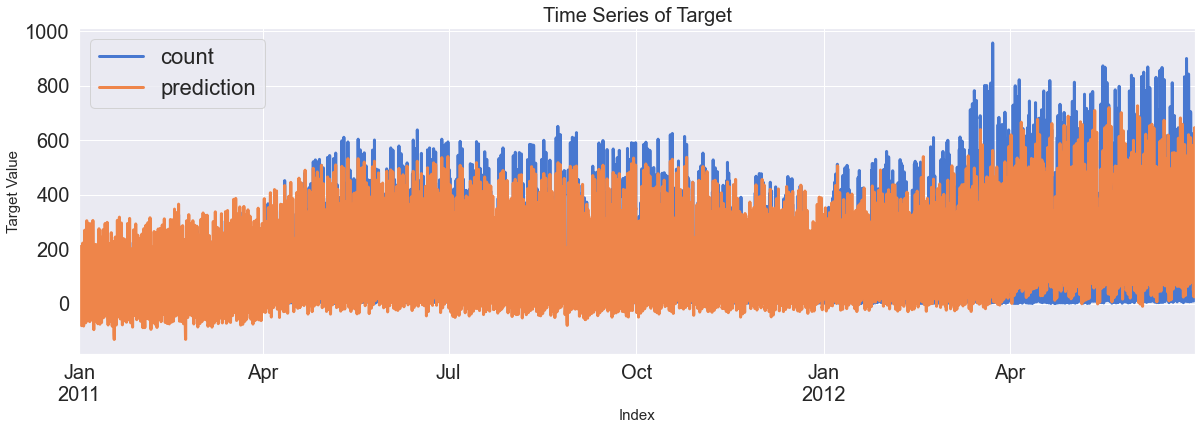

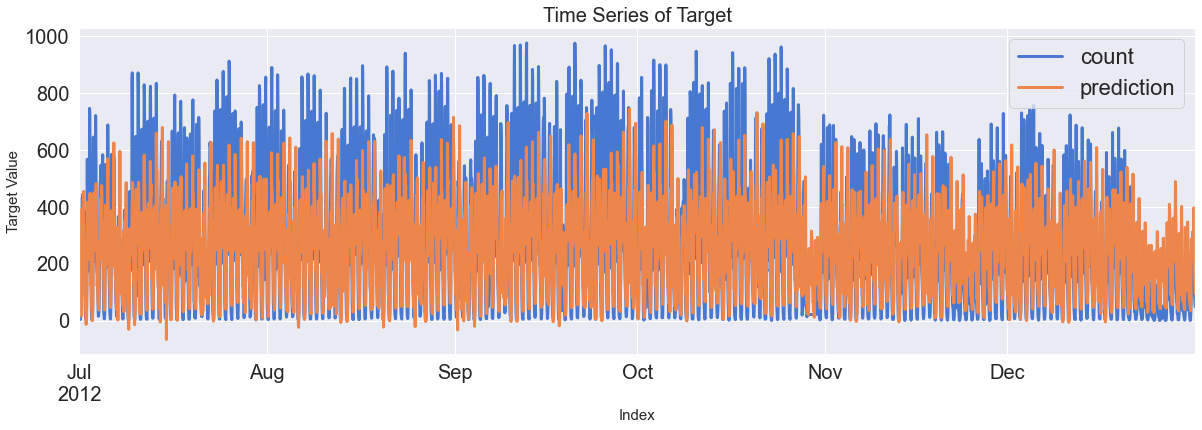

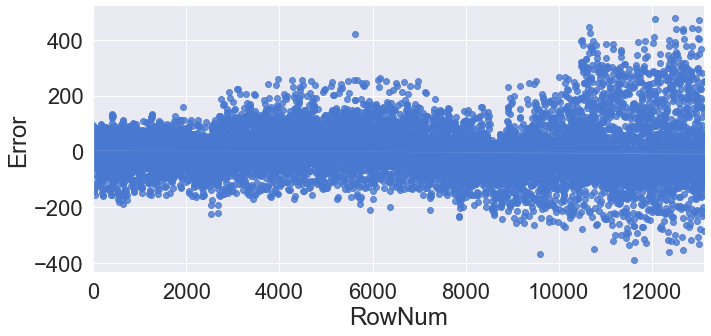

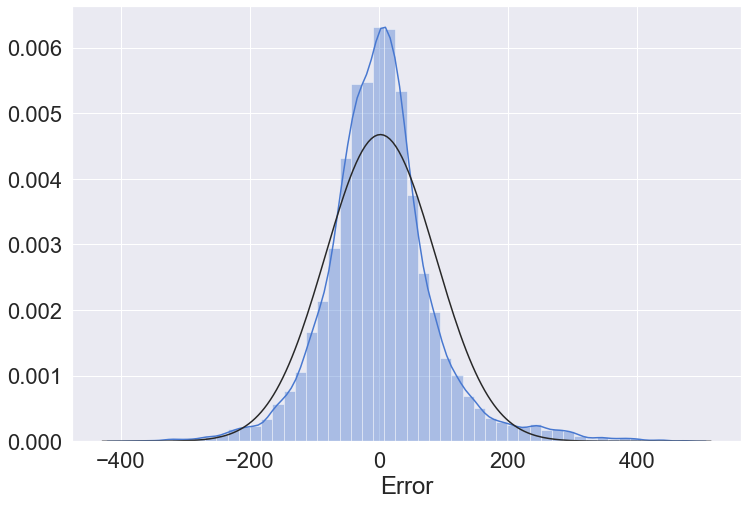

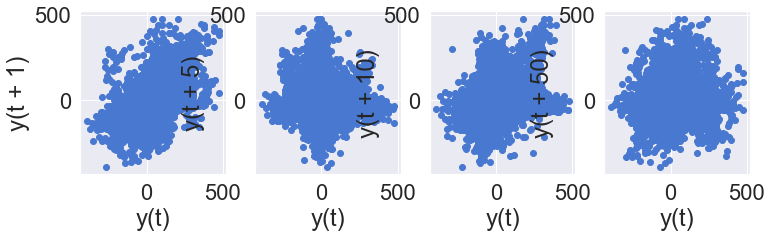

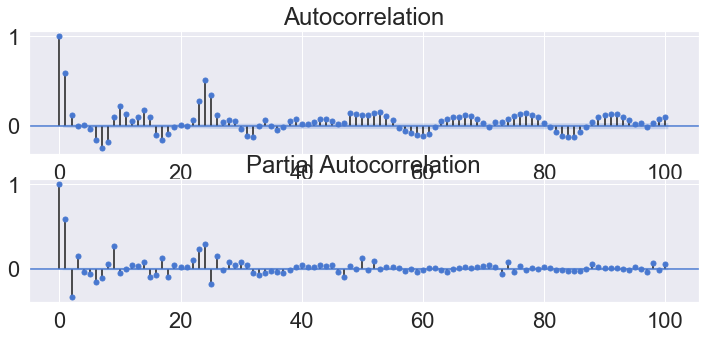

In [46]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_all = pd.read_csv(location)

# Feature Engineering
data_fe = feature_engineering(raw_all)
### Reality ###
target = ["count_trend", "count_seasonal", "count_day", "count_week", "count_diff"]
data_feR = duplicate_values(data_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
X_colname = [x for x in data_fe.columns if x not in Y_colname+X_remove]
x_tr_feR, x_teR, Y_train_feR, y_teR = datasplit_ts(data_feR, Y_colname, X_colname, "2012-07-01")
### Reality ###
target = ["count_lag1", "count_lag2"]
x_teR = feature_engineering_lag_modified(y_teR, x_teR, target)
###############
### Scaling ###
x_tr_feRS, x_teRS = feature_engineering_scaling(preprocessing.Normalizer(), x_tr_feR, x_teR)
###############
### Multicollinearity ###
print("Number_of_Total_X: ", len(x_tr_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(x_tr_feRS, 12)
print("Number_of_Selected_X: ", len(X_colname_vif))
x_tr_feRSM, x_teRSM = x_tr_feRS[X_colname_vif].copy(), x_teRS[X_colname_vif].copy()
#########################

# Applying Base Model
fit_reg1_feRSM = sm.OLS(Y_train_feR, x_tr_feRSM).fit()
display(fit_reg1_feRSM.summary())
pred_tr_reg1_feRSM = fit_reg1_feRSM.predict(x_tr_feRSM).values
pred_te_reg1_feRSM = fit_reg1_feRSM.predict(x_teRSM).values

# Evaluation
Score_reg1_feRSM, Resid_tr_reg1_feRSM, Resid_te_reg1_feRSM = evaluation_trte(Y_train_feR, pred_tr_reg1_feRSM,
                                                                   y_teR, pred_te_reg1_feRSM, graph_on=True)
display(Score_reg1_feRSM)

# Error Analysis
error_analysis(Resid_tr_reg1_feRSM, ["Error"], x_tr_feRSM, graph_on=True)

# Final Result Comparison: 전처리(Raw/Reality/Scaling/Multicollinearity) 별 결과비교

In [47]:
# comparison of precision
display(Score_reg1_rd)
display(Score_reg1_feR)
display(Score_reg1_feRS)
display(Score_reg1_feRSM)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


,MAE,MSE,MAPE
Train,27.18,"2,324.78",80.36
Test,113.06,"25,908.84",129.35


,MAE,MSE,MAPE
Train,60.84,"7,288.40",202.42
Test,99.87,"19,151.40",153.34


In [48]:
# comparison of metrics
comparison_r2 = pd.DataFrame([fit_reg1_rd.rsquared_adj, fit_reg1_feR.rsquared_adj, 
                              fit_reg1_feRS.rsquared_adj, fit_reg1_feRSM.rsquared_adj], 
                             index=["rd", "feR", "feRS", "feRSM"], columns=["R^2_adj"]).T
comparison_fvalue = pd.DataFrame([fit_reg1_rd.fvalue, fit_reg1_feR.fvalue, 
                                  fit_reg1_feRS.fvalue, fit_reg1_feRSM.fvalue], 
                                 index=["rd", "feR", "feRS", "feRSM"], columns=["F-statistics"]).T
comparison_fpvalue = pd.DataFrame([fit_reg1_rd.f_pvalue, fit_reg1_feR.f_pvalue, 
                                   fit_reg1_feRS.f_pvalue, fit_reg1_feRSM.f_pvalue], 
                                  index=["rd", "feR", "feRS", "feRSM"], columns=["prob(F-stat.)"]).T
comparison_aic = pd.DataFrame([fit_reg1_rd.aic, fit_reg1_feR.aic, 
                              fit_reg1_feRS.aic, fit_reg1_feRSM.aic], 
                             index=["rd", "feR", "feRS", "feRSM"], columns=["aic"]).T
comparison_bic = pd.DataFrame([fit_reg1_rd.bic, fit_reg1_feR.bic, 
                               fit_reg1_feRS.bic, fit_reg1_feRSM.bic], 
                              index=["rd", "feR", "feRS", "feRSM"], columns=["bic"]).T
pd.concat([comparison_r2, comparison_fvalue, comparison_fpvalue, comparison_aic, comparison_bic], axis=0)

,rd,feR,feRS,feRSM
R^2_adj,0.64,0.91,0.96,0.86
F-statistics,"2,889.02","5,657.99","12,011.02","6,924.95"
prob(F-stat.),0.00,0.00,0.00,0.00
aic,"166,857.95","139,283.69","139,063.76","154,040.60"
bic,"166,917.81","139,463.27","139,243.34","154,130.39"


In [49]:
# comparison of coefficients
comparison_fit_rd = pd.concat([pd.DataFrame(fit_reg1_rd.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_rd.pvalues, columns=["prob(coef)"])], axis=1)
comparison_fit_feR = pd.concat([pd.DataFrame(fit_reg1_feR.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_feR.pvalues, columns=["prob(coef)"])], axis=1)
comparison_fit_feRS = pd.concat([pd.DataFrame(fit_reg1_feRS.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_feRS.pvalues, columns=["prob(coef)"])], axis=1)
comparison_fit_feRSM = pd.concat([pd.DataFrame(fit_reg1_feRSM.params, columns=["coef"]), 
                               pd.DataFrame(fit_reg1_feRSM.pvalues, columns=["prob(coef)"])], axis=1)
pd.concat([comparison_fit_rd, comparison_fit_feR, comparison_fit_feRS, comparison_fit_feRSM], axis=1)

,coef,prob(coef),coef,prob(coef),coef,prob(coef),coef,prob(coef)
season,3.37,0.01,2.75,0.00,"4,315.62",0.03,nan,nan
holiday,-6.29,0.40,0.62,0.85,-409.21,0.95,"71,406.59",0.00
workingday,10.36,0.00,2.20,0.15,"2,915.86",0.35,"76,954.13",0.00
weather,7.19,0.00,-5.88,0.00,"-11,054.49",0.00,"-24,231.78",0.00
temp,-7.85,0.00,0.56,0.25,"1,593.80",0.11,nan,nan
atemp,16.07,0.00,0.40,0.34,112.30,0.90,nan,nan
humidity,-1.74,0.00,-0.07,0.01,-112.49,0.05,nan,nan
windspeed,2.27,0.00,-0.12,0.03,-242.00,0.04,-234.11,0.20
count_trend,nan,nan,0.07,0.00,119.38,0.01,nan,nan
count_seasonal,nan,nan,0.19,0.00,356.49,0.00,"1,270.93",0.00


In [53]:
target = Y_train_feR.copy()
stationarity_adf_test(target, "count")

,Stationarity_adf
Test Statistics,-6.84
p-value,0.00
Used Lag,41.00
Used Observations,"13,086.00"
Critical Value(1%),-3.43
Maximum Information Criteria,"141,050.42"


In [54]:
stationarity_kpss_test(target, "count")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


,Stationarity_kpss
Test Statistics,12.30
p-value,0.01
Used Lag,41.00
Critical Value(10%),0.35
